In [18]:
%pip install scikit-learn
%pip install xgboost

import os
os._exit( 0 )


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


: 

In [1]:
import numpy as np
import pandas as pd

# these may be independently useful
demographic_variables = [ 'sex', 'age', 'distance_to_club' ]
behavioral_variables = [ 'visits', 'spend' ]

In [2]:
#
# This cell exists only to form a dataset, if you've got a CSV you can bypass it
#

months = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ]
customers = 10000
active_threshold = -2

simulated_data = np.random.normal( size = ( len( months ) * customers, len( demographic_variables ) + len( behavioral_variables ) + 1 ) )
simulated_data = pd.DataFrame( simulated_data, columns = [ *demographic_variables, *behavioral_variables, 'active'] )
simulated_data = simulated_data.assign( customer_id = lambda _df: _df.index // len( months ) )
simulated_data = simulated_data.assign( month = months * customers )

simulated_data = simulated_data.assign( active = lambda _df: np.where( _df.active < active_threshold, 0, 1 ) )
initial_demos = simulated_data.query( 'month == 1' )[['customer_id',*demographic_variables]]
simulated_data = simulated_data.drop( demographic_variables, axis = 1 ).merge( initial_demos, on = 'customer_id' )
first_churn_month = simulated_data.query( 'active == 0' ).groupby( 'customer_id' )['month'].min().reset_index().rename( columns = { 'month': 'first_churn_month' } )
simulated_data = simulated_data \
    .merge( first_churn_month, on = 'customer_id', how = 'left' ) \
    .assign( first_churn_month = lambda _df: _df.first_churn_month.fillna( max( months ) + 1 ) ) \
    .assign( sex = lambda _df: np.where( _df.sex < 1e-1, 1, 0 ) ) \
    .query( 'month <= first_churn_month' )

In [3]:
#
# Merge the dataset on itself, last month
# Note that this assumes that demographics are stable
#
data = simulated_data
data = data \
    .assign( month = lambda _df: _df.month - 1 ) \
    .merge(
        data \
            [['customer_id','month',*behavioral_variables]] \
            .rename( columns = { column: f'last_{column}' for column in behavioral_variables } ),
        on = [ 'customer_id', 'month' ]
    ) \
    .assign( month = lambda _df: _df.month + 1 )

for column in behavioral_variables:
    data = data.assign( **{ f'delta_{column}': lambda _df: _df[column] - _df[f'last_{column}'] } )
    data = data.assign( **{ f'delta_{column}_pct': lambda _df: _df[f'delta_{column}'] / _df[f'last_{column}'] } )



In [30]:
#
# Train a model
#
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import xgboost

#
# In reality, we should always specify a validation set to avoid model overfit.
# These parameters are left in for easy visualization of what happens when you
# *don't* specify a validation dataset (note that XGBoost will almost perfectly
# fit random data)
#
validation_set_size = 0.3
use_validation_set = True

independent_variables = [
    *demographic_variables,
    *[ f'last_{variable}' for variable in behavioral_variables ],
    *[ f'delta_{variable}' for variable in behavioral_variables ],
    *[ f'delta_{variable}_pct' for variable in behavioral_variables ]
]
dependent_variables = 'active'

#
# Train the classifier
#
xgb = xgboost.XGBClassifier()

if use_validation_set:
    X_train, X_test, Y_train, Y_test = train_test_split( data[independent_variables], data[dependent_variables], test_size = validation_set_size )
    balanced_weights = class_weight.compute_sample_weight( class_weight = 'balanced', y = Y_train )
    xgb_res = xgb.fit( X_train, Y_train, sample_weight = balanced_weights, eval_set = [ ( X_test, Y_test ) ] )

else:
    balanced_weights = class_weight.compute_sample_weight( class_weight = 'balanced', y = data[dependent_variables] )
    xgb_res = xgb.fit( data[independent_variables], data[dependent_variables], sample_weight = balanced_weights )

[0]	validation_0-logloss:0.68540
[1]	validation_0-logloss:0.67240
[2]	validation_0-logloss:0.66610
[3]	validation_0-logloss:0.66037
[4]	validation_0-logloss:0.65333
[5]	validation_0-logloss:0.64254
[6]	validation_0-logloss:0.63916
[7]	validation_0-logloss:0.63322
[8]	validation_0-logloss:0.62615
[9]	validation_0-logloss:0.61973
[10]	validation_0-logloss:0.61602
[11]	validation_0-logloss:0.60914
[12]	validation_0-logloss:0.60455
[13]	validation_0-logloss:0.60020
[14]	validation_0-logloss:0.59688
[15]	validation_0-logloss:0.58876
[16]	validation_0-logloss:0.58206
[17]	validation_0-logloss:0.57414
[18]	validation_0-logloss:0.57041
[19]	validation_0-logloss:0.56348
[20]	validation_0-logloss:0.55784
[21]	validation_0-logloss:0.55251
[22]	validation_0-logloss:0.54743
[23]	validation_0-logloss:0.54340
[24]	validation_0-logloss:0.53827
[25]	validation_0-logloss:0.53392
[26]	validation_0-logloss:0.52511
[27]	validation_0-logloss:0.52154
[28]	validation_0-logloss:0.51800
[29]	validation_0-loglos

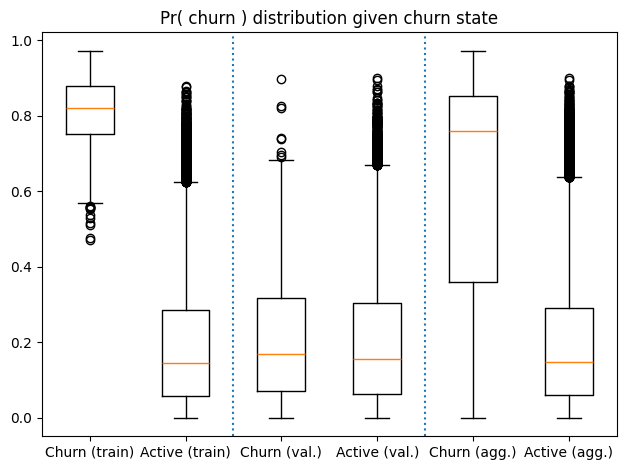

In [32]:
#
# Use it
#
import matplotlib.pyplot as plot

pr_churn = xgb_res.predict_proba( data[independent_variables] )[:,0]
predictions = data[['customer_id','month','active']].assign( pr_churn = pr_churn )

if use_validation_set:
    pr_churn_train = xgb_res.predict_proba( X_train[independent_variables] )[:,0]
    pr_churn_validation = xgb_res.predict_proba( X_test[independent_variables] )[:,0]

    predictions_train = pd.concat( [ X_train, Y_train ], axis = 1 )[['active']].assign( pr_churn = pr_churn_train )
    predictions_validation = pd.concat( [ X_test, Y_test ], axis = 1 )[['active']].assign( pr_churn = pr_churn_validation )

    plot.boxplot(
        [ predictions_train.query( f'active == {active}' ).pr_churn for active in [ 0, 1 ] ]
        + [ predictions_validation.query( f'active == {active}' ).pr_churn for active in [ 0, 1 ] ]
        + [ predictions.query( f'active == {active}' ).pr_churn for active in [ 0, 1 ] ],
        labels = [ 'Churn (train)', 'Active (train)' ]
        + [ 'Churn (val.)', 'Active (val.)' ]
        + [ 'Churn (agg.)', 'Active (agg.)' ]
    )
    plot.axvline( 2.5, linestyle = 'dotted' )
    plot.axvline( 4.5, linestyle = 'dotted' )

else:
    plot.boxplot( [ predictions.query( f'active == {active}' ).pr_churn for active in [ 0, 1 ] ], labels = [ 'Churn', 'Active' ] )

plot.title( 'Pr( churn ) distribution given churn state' )
plot.tight_layout()
plot.show()